This file containes code for implementation of DeepHit model on Doctor's data, and related experiments. This notebook have code for single risk.

In [7]:
# %pip install sklearn-pandas
# %pip install torchtuples
# %pip install pycox


In [8]:
import plotly.io as pio
pio.renderers.default = 'iframe'

In [10]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
pd.options.plotting.backend = "plotly"

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch # For building the networks 
import torchtuples as tt # Some useful functions


# from pycox.models import PMF
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [20]:
#loading data provided by doctors in dataframe
data = pd.read_csv('dr_data.csv')
data

,Unnamed: 0.1,Unnamed: 0,PatientId,PatientCurrentStatus,ExaminDt,"ALBUMIN, Serum",HAEMOGLOBIN,"PARATHORMONE (intact), Plasma","PHOSPHORUS, Serum","POTASSIUM, Serum",Tobacco,Days of Hypertension prior dialysis,Hospitalization count,Access creation count,isDiabetic,Start Date,End Date,years,year,Status
0,0,0,35150,Death,2020-09-28,3.5,9,NaN,7.0,6.2,0.0,3596.0,1.0,1.0,0,2019-11-06,2020-10-02,331.0,327.0,1
1,1,1,35150,Death,2020-09-28,3.5,9,NaN,7.0,6.2,0.0,3596.0,1.0,1.0,0,2019-11-06,2020-10-02,331.0,327.0,1
2,2,3,35331,Death,2019-12-14,4.0,11.7,NaN,5.8,5.2,0.0,2970.0,NaN,2.0,0,2018-02-18,2020-04-24,796.0,664.0,1
3,3,4,35331,Death,2020-01-14,3.9,10.9,NaN,6.5,5.9,0.0,2970.0,NaN,2.0,0,2018-02-18,2020-04-24,796.0,695.0,1
4,4,5,35331,Death,2020-02-14,4.0,12.6,NaN,5.8,5.9,0.0,2970.0,NaN,2.0,0,2018-02-18,2020-04-24,796.0,726.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10043,10043,9047,12679,Alive,2015-04-07,NaN,NaN,NaN,NaN,4.2,0.0,4079.0,NaN,1.0,1,2013-12-01,2022-03-23,3034.0,492.0,0
10044,10044,9048,12679,Alive,2015-07-28,NaN,NaN,NaN,NaN,4.6,0.0,4079.0,NaN,1.0,1,2013-12-01,2022-03-23,3034.0,604.0,0
10045,10045,9049,17505,Alive,2015-07-11,NaN,NaN,NaN,NaN,4.5,NaN,4932.0,NaN,NaN,1,2014-09-01,2022-03-23,2760.0,313.0,0
10046,10046,9051,20609,Alive,2015-07-16,NaN,NaN,NaN,NaN,6.0,0.0,NaN,1.0,1.0,0,2012-01-02,2022-03-23,3733.0,1291.0,0


In [21]:
data['ExaminDt'] = pd.to_datetime(data['ExaminDt'])
data['Start Date'] = pd.to_datetime(data['Start Date'])
data['End Date'] = pd.to_datetime(data['End Date'])

In [22]:
df = data.copy()
df.set_index('PatientId')

df = df.sort_values(['ExaminDt'])
df = df.drop_duplicates(['PatientId'], keep='last')
df

,Unnamed: 0.1,Unnamed: 0,PatientId,PatientCurrentStatus,ExaminDt,"ALBUMIN, Serum",HAEMOGLOBIN,"PARATHORMONE (intact), Plasma","PHOSPHORUS, Serum","POTASSIUM, Serum",Tobacco,Days of Hypertension prior dialysis,Hospitalization count,Access creation count,isDiabetic,Start Date,End Date,years,year,Status
8939,8939,7376,9787,Transfer,2014-02-08,NaN,9.7,NaN,NaN,8.2,NaN,NaN,NaN,NaN,0,2013-07-01,2018-01-01,1645.0,222.0,0
8953,8953,7402,14729,Alive,2015-03-03,NaN,11.2,NaN,NaN,4.3,NaN,NaN,NaN,NaN,0,2014-04-07,2022-03-23,2907.0,330.0,0
3531,3531,5365,20221,Death,2015-08-17,NaN,8.1,NaN,NaN,5.0,NaN,NaN,NaN,NaN,0,2015-05-15,2021-08-23,2292.0,94.0,1
9483,9483,8209,13303,Alive,2015-08-27,NaN,11.8,NaN,NaN,4.3,NaN,NaN,NaN,NaN,0,2014-01-10,2022-03-23,2994.0,594.0,0
9516,9516,8297,14984,Alive,2015-09-28,NaN,9.9,NaN,NaN,4.6,NaN,NaN,NaN,NaN,0,2013-12-29,2022-03-23,3006.0,638.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6809,6809,4413,9752,Alive,2022-03-21,3.7,11.5,NaN,4.5,5.7,0.0,NaN,2.0,4.0,1,2015-10-01,2022-03-23,2365.0,2363.0,0
8648,8648,6937,17619,Alive,2022-03-22,NaN,11.4,NaN,NaN,NaN,0.0,NaN,6.0,1.0,0,2019-03-30,2022-03-23,1089.0,1088.0,0
4617,4617,948,66473,Alive,2022-03-22,3.2,7.8,NaN,6.4,4.9,3.0,1268.0,2.0,3.0,1,2021-06-22,2022-03-23,274.0,273.0,0
5653,5653,2498,28158,Alive,2022-03-22,3.8,9.8,NaN,1.6,5.5,3.0,NaN,1.0,2.0,0,2016-10-07,2022-03-23,1993.0,1992.0,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 572 entries, 8939 to 7068
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Unnamed: 0.1                         572 non-null    int64         
 1   Unnamed: 0                           572 non-null    int64         
 2   PatientId                            572 non-null    int64         
 3   PatientCurrentStatus                 572 non-null    object        
 4   ExaminDt                             572 non-null    datetime64[ns]
 5   ALBUMIN, Serum                       457 non-null    float64       
 6   HAEMOGLOBIN                          530 non-null    object        
 7   PARATHORMONE (intact), Plasma        50 non-null     float64       
 8   PHOSPHORUS, Serum                    453 non-null    float64       
 9   POTASSIUM, Serum                     476 non-null    float64       
 10  Tobacco   

In [24]:
temp = df.dropna(how="any")
temp

,Unnamed: 0.1,Unnamed: 0,PatientId,PatientCurrentStatus,ExaminDt,"ALBUMIN, Serum",HAEMOGLOBIN,"PARATHORMONE (intact), Plasma","PHOSPHORUS, Serum","POTASSIUM, Serum",Tobacco,Days of Hypertension prior dialysis,Hospitalization count,Access creation count,isDiabetic,Start Date,End Date,years,year,Status
288,288,449,35289,Death,2018-05-24,3.8,10.2,335.6,6.9,5.0,0.0,6551.0,1.0,2.0,1,2017-12-08,2018-06-25,199.0,167.0,1
689,689,1018,36135,Death,2018-12-19,3.2,10.5,508.1,5.8,5.9,0.0,798.0,2.0,2.0,1,2018-03-09,2019-01-13,310.0,285.0,1
2842,2842,4250,13948,Death,2019-01-01,3.2,11.7,813.6,4.8,4.5,0.0,6392.0,2.0,1.0,0,2014-12-01,2020-11-05,2166.0,1492.0,1
2313,2313,3378,42828,Death,2019-09-17,2.5,9.5,42.0,3.2,5.4,0.0,14658.0,1.0,3.0,1,2019-02-18,2019-12-22,307.0,211.0,1
2676,2676,4024,12357,Death,2020-10-15,3.7,11.8,179.2,4.3,4.9,0.0,8037.0,1.0,1.0,1,2018-10-03,2020-10-31,759.0,743.0,1
1125,1125,1574,27273,Death,2021-03-19,2.0,9.3,521.7,5.8,4.9,3.0,2322.0,1.0,3.0,0,2021-01-09,2021-06-06,148.0,69.0,1
4895,4895,1440,15922,Alive,2022-02-17,4.3,6.6,57.6,4.7,4.2,0.0,1105.0,2.0,2.0,0,2021-01-10,2022-03-23,437.0,403.0,0
4970,4970,1572,19549,Alive,2022-03-16,3.9,8,578.7,7.6,6.5,0.0,3364.0,2.0,4.0,1,2016-03-18,2022-03-23,2196.0,2189.0,0
7648,7648,5425,50862,Alive,2022-03-16,3.2,9.3,369.0,1.1,4.2,0.0,5688.0,1.0,4.0,1,2020-07-29,2022-03-23,602.0,595.0,0
5070,5070,1694,26963,Alive,2022-03-16,3.8,13.4,934.5,5.8,5.5,0.0,4433.0,4.0,4.0,1,2018-09-20,2022-03-23,1280.0,1273.0,0


If we drop all rows corresponding to null values we left with only 12 samples , insufficient for any model.        
Hence remove 'PARATHORMONE (intact), Plasma','Hospitalization count' columns having few non-null values

In [25]:
#dropping 1st column indicating serial number
df.drop(['Unnamed: 0.1','Unnamed: 0','PARATHORMONE (intact), Plasma','Hospitalization count'], axis='columns',inplace = True)
df

,PatientId,PatientCurrentStatus,ExaminDt,"ALBUMIN, Serum",HAEMOGLOBIN,"PHOSPHORUS, Serum","POTASSIUM, Serum",Tobacco,Days of Hypertension prior dialysis,Access creation count,isDiabetic,Start Date,End Date,years,year,Status
8939,9787,Transfer,2014-02-08,NaN,9.7,NaN,8.2,NaN,NaN,NaN,0,2013-07-01,2018-01-01,1645.0,222.0,0
8953,14729,Alive,2015-03-03,NaN,11.2,NaN,4.3,NaN,NaN,NaN,0,2014-04-07,2022-03-23,2907.0,330.0,0
3531,20221,Death,2015-08-17,NaN,8.1,NaN,5.0,NaN,NaN,NaN,0,2015-05-15,2021-08-23,2292.0,94.0,1
9483,13303,Alive,2015-08-27,NaN,11.8,NaN,4.3,NaN,NaN,NaN,0,2014-01-10,2022-03-23,2994.0,594.0,0
9516,14984,Alive,2015-09-28,NaN,9.9,NaN,4.6,NaN,NaN,NaN,0,2013-12-29,2022-03-23,3006.0,638.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6809,9752,Alive,2022-03-21,3.7,11.5,4.5,5.7,0.0,NaN,4.0,1,2015-10-01,2022-03-23,2365.0,2363.0,0
8648,17619,Alive,2022-03-22,NaN,11.4,NaN,NaN,0.0,NaN,1.0,0,2019-03-30,2022-03-23,1089.0,1088.0,0
4617,66473,Alive,2022-03-22,3.2,7.8,6.4,4.9,3.0,1268.0,3.0,1,2021-06-22,2022-03-23,274.0,273.0,0
5653,28158,Alive,2022-03-22,3.8,9.8,1.6,5.5,3.0,NaN,2.0,0,2016-10-07,2022-03-23,1993.0,1992.0,0


In [26]:
df1 = df.dropna(how='any',axis=0)
df1

,PatientId,PatientCurrentStatus,ExaminDt,"ALBUMIN, Serum",HAEMOGLOBIN,"PHOSPHORUS, Serum","POTASSIUM, Serum",Tobacco,Days of Hypertension prior dialysis,Access creation count,isDiabetic,Start Date,End Date,years,year,Status
3001,32699,Death,2017-08-08,3.4,8.6,3.2,3.4,0.0,7305.0,1.0,1,2017-08-01,2020-07-07,1071.0,7.0,1
5336,32823,Alive,2017-10-17,3.3,10.7,4.5,4.5,1.0,3630.0,1.0,1,2017-08-09,2022-03-23,1687.0,69.0,0
1664,31416,Death,2018-01-11,2.7,10.2,4.2,4.4,0.0,7251.0,1.0,1,2017-04-08,2018-02-13,311.0,278.0,1
7290,19218,Alive,2018-02-19,2.7,7.3,2.3,4.5,0.0,153.0,5.0,0,2014-01-01,2022-03-23,3003.0,1510.0,0
3088,14690,Death,2018-02-20,3.0,12,5.4,6.6,0.0,2557.0,1.0,0,2014-11-01,2018-08-02,1370.0,1207.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6093,53182,Alive,2022-03-19,4.2,13,6.2,4.2,2.0,3166.0,4.0,1,2020-09-01,2022-03-23,568.0,564.0,0
8274,51811,Alive,2022-03-19,4.0,10.3,5.6,5.2,0.0,6454.0,1.0,1,2020-09-02,2022-03-23,567.0,563.0,0
7006,99216,Alive,2022-03-21,2.9,7.4,4.8,4.6,0.0,1044.0,4.0,1,2021-11-10,2022-03-23,133.0,131.0,0
8310,51037,Alive,2022-03-21,4.3,10.3,3.4,4.3,0.0,2847.0,3.0,0,2021-10-18,2022-03-23,156.0,154.0,0


In [34]:
df1['HAEMOGLOBIN'] = df1['HAEMOGLOBIN'].astype('float64')

/tmp/ipykernel_1456750/3412262637.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [35]:
df1.drop(['PatientCurrentStatus','ExaminDt','Start Date','End Date'], axis='columns',inplace = True)
print(df1.info())
print(df1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255 entries, 3001 to 4617
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PatientId                            255 non-null    int64  
 1   ALBUMIN, Serum                       255 non-null    float64
 2   HAEMOGLOBIN                          255 non-null    float64
 3   PHOSPHORUS, Serum                    255 non-null    float64
 4   POTASSIUM, Serum                     255 non-null    float64
 5   Tobacco                              255 non-null    float64
 6   Days of Hypertension prior dialysis  255 non-null    float64
 7   Access creation count                255 non-null    float64
 8   isDiabetic                           255 non-null    int64  
 9   years                                255 non-null    float64
 10  year                                 255 non-null    float64
 11  Status                      

/tmp/ipykernel_1456750/3850603334.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
np.random.seed(987)
_ = torch.manual_seed(987)

In [36]:
#patient status (alive or death)
df1.groupby(["Status"]).count().reset_index().plot(x='Status', y='PatientId', kind='bar')


In [37]:
df_train = df1
df_test = df_train.sample(frac=0.15)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.20)
df_train = df_train.drop(df_val.index)

In [38]:
#checking if data is balanced
print(df_train['Status'].value_counts())
print(df_val['Status'].value_counts())
print(df_test['Status'].value_counts())

0    100
1     74
Name: Status, dtype: int64
0    23
1    20
Name: Status, dtype: int64
0    20
1    18
Name: Status, dtype: int64


In [39]:
df_train.describe()

,PatientId,"ALBUMIN, Serum",HAEMOGLOBIN,"PHOSPHORUS, Serum","POTASSIUM, Serum",Tobacco,Days of Hypertension prior dialysis,Access creation count,isDiabetic,years,year,Status
count,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000,174.000000
mean,37843.310345,3.648276,9.541379,5.295402,5.062069,0.436782,2953.511494,2.281609,0.528736,1033.793103,911.137931,0.425287
std,18018.279919,0.635439,1.757004,1.702118,0.752605,0.914888,2949.249852,1.408482,0.500614,883.354774,880.652709,0.495813
min,6099.000000,1.600000,5.800000,1.100000,3.100000,0.000000,1.000000,1.000000,0.000000,34.000000,7.000000,0.000000
25%,24488.250000,3.200000,8.300000,4.200000,4.500000,0.000000,976.250000,1.000000,0.000000,329.000000,244.500000,0.000000
50%,37699.500000,3.700000,9.600000,5.000000,5.100000,0.000000,1826.000000,2.000000,1.000000,767.000000,568.000000,0.000000
75%,50354.750000,4.100000,10.775000,6.300000,5.575000,0.000000,4343.000000,3.000000,1.000000,1490.250000,1416.750000,1.000000
max,98769.000000,5.000000,13.700000,10.900000,6.800000,3.000000,14658.000000,9.000000,1.000000,4464.000000,4460.000000,1.000000


In [40]:
cols_standardize = ['ALBUMIN, Serum','PHOSPHORUS, Serum', 
                    'POTASSIUM, Serum', 'Tobacco',
                    'Days of Hypertension prior dialysis',
                    'Access creation count','year']
cols_leave = []

#selecting standardScaler for numeric columns
standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [41]:
standardize

[(['ALBUMIN, Serum'], StandardScaler()),
 (['PHOSPHORUS, Serum'], StandardScaler()),
 (['POTASSIUM, Serum'], StandardScaler()),
 (['Tobacco'], StandardScaler()),
 (['Days of Hypertension prior dialysis'], StandardScaler()),
 (['Access creation count'], StandardScaler()),
 (['year'], StandardScaler())]

In [42]:
#Applying transformation on different data partition
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [43]:
x_train.shape

(174, 7)

In [44]:
num_durations = 10

scheme = 'equidistant' # or quantiles
labtrans = DeepHitSingle.label_transform(num_durations, scheme)

# get_target = lambda df: (df['duration'].values, df['event'].values)
#durations is in 'years' here
get_target = lambda df1: (df1['years'].values, df1['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

#don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [45]:
#equidistant 10 bins according to years column
labtrans.cuts

array([   0.,  496.,  992., 1488., 1984., 2480., 2976., 3472., 3968.,
       4464.])

In [46]:
print("Years test", durations_test)
print("status test", events_test)

Years test [5348. 1286.  233.  139. 1144.  133. 2972. 1079.  320. 1578. 2924.  396.
  820. 1695.  460.   69.  685.  719. 1116.  137. 1458.  529.  796.   22.
 2610.  339.  420.  242.  253.  201.  205. 1427.  688.  964.  179. 2466.
 1687.  241.]
status test [0 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0
 1]


In [47]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features #here 10(num_duration)
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [48]:
model = DeepHitSingle(net, tt.optim.Adam, duration_index=labtrans.cuts) #alpha here is weight to log likelihood loss than to log ranking loss

<Axes: xlabel='lr', ylabel='bach_loss (smoothed)'>

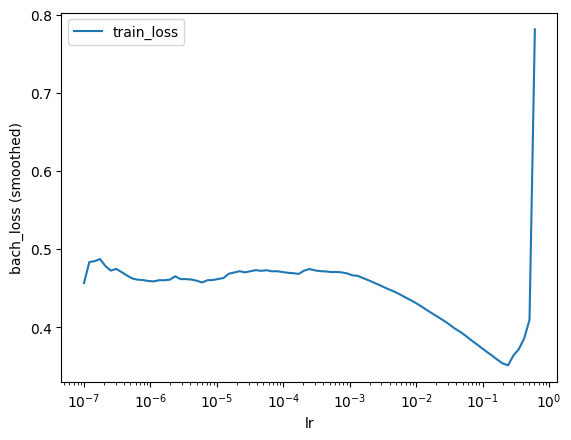

In [49]:
pd.options.plotting.backend = "matplotlib"

batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=3)
lr_finder.plot()

In [50]:
t = lr_finder.get_best_lr()
t

0.02420128264794396

In [69]:
%%time
res = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 0.4566,	val_loss: 0.4009
1:	[0s / 0s],		train_loss: 0.3580,	val_loss: 0.3782
2:	[0s / 0s],		train_loss: 0.3131,	val_loss: 0.3626
3:	[0s / 0s],		train_loss: 0.2758,	val_loss: 0.3528
4:	[0s / 0s],		train_loss: 0.2586,	val_loss: 0.3472
5:	[0s / 0s],		train_loss: 0.2487,	val_loss: 0.3434
6:	[0s / 0s],		train_loss: 0.2448,	val_loss: 0.3409
7:	[0s / 0s],		train_loss: 0.2263,	val_loss: 0.3376
8:	[0s / 0s],		train_loss: 0.2191,	val_loss: 0.3363
9:	[0s / 0s],		train_loss: 0.2054,	val_loss: 0.3388
10:	[0s / 0s],		train_loss: 0.2009,	val_loss: 0.3428
11:	[0s / 0s],		train_loss: 0.2019,	val_loss: 0.3471
12:	[0s / 0s],		train_loss: 0.2013,	val_loss: 0.3331
13:	[0s / 0s],		train_loss: 0.1878,	val_loss: 0.3169
14:	[0s / 0s],		train_loss: 0.1879,	val_loss: 0.2984
15:	[0s / 0s],		train_loss: 0.1807,	val_loss: 0.2911
16:	[0s / 0s],		train_loss: 0.1781,	val_loss: 0.2907
17:	[0s / 0s],		train_loss: 0.1738,	val_loss: 0.2958
18:	[0s / 0s],		train_loss: 0.1672,	val_loss: 0.3013
19:

In [70]:
pd.options.plotting.backend = "plotly"
fig = res.plot()
fig.update_layout(xaxis_title = "Epochs", yaxis_title = "loss")

In [73]:
print("validation loss: ",model.score_in_batches(val))
print("Training loss: ",model.score_in_batches(train))

validation loss:  {'loss': 0.29073822498321533}
Training loss:  {'loss': 0.16934117674827576}


In [76]:
#Survival curve for 5 test patients
surv = model.predict_surv_df(x_test)
fig = px.line(surv.iloc[:,:5],line_shape='hv')
fig.update_layout(xaxis_title="Time", yaxis_title="Survival Probability")
fig

In [34]:
surv #index is cuts

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0.000000,0.926741,0.923111,0.994894,0.988112,0.915147,0.989563,0.884189,0.841209,0.909594,0.925964,...,0.965737,0.991430,0.916580,0.961725,0.979542,0.933379,0.949986,0.948882,0.896465,0.933812
594.222222,0.610472,0.814519,0.993420,0.985870,0.552257,0.988005,0.547551,0.834750,0.737192,0.690407,...,0.887246,0.987782,0.648938,0.848193,0.976762,0.913101,0.820112,0.663668,0.649782,0.801090
1188.444444,0.456828,0.687140,0.988044,0.972206,0.444146,0.972689,0.395060,0.783347,0.540264,0.535091,...,0.740186,0.971836,0.467080,0.723143,0.943183,0.787672,0.706129,0.489975,0.513152,0.717883
1782.666667,0.356986,0.600512,0.957002,0.938696,0.354301,0.903941,0.341063,0.628463,0.466015,0.403208,...,0.632936,0.932412,0.381691,0.594403,0.840977,0.730805,0.643009,0.425616,0.410860,0.623715
2376.888889,0.311139,0.486856,0.776398,0.814138,0.317010,0.885774,0.285314,0.616395,0.388624,0.382989,...,0.562179,0.815789,0.332929,0.556362,0.816671,0.636761,0.564417,0.325992,0.371994,0.522409
2971.111111,0.286469,0.372810,0.423939,0.547107,0.277006,0.862925,0.226166,0.548934,0.325821,0.322811,...,0.433338,0.529657,0.288021,0.464038,0.590995,0.471267,0.390269,0.260175,0.326350,0.419915
3565.333333,0.237748,0.270221,0.223585,0.287778,0.238566,0.745775,0.191265,0.463167,0.257585,0.285498,...,0.309767,0.280327,0.245403,0.355434,0.405841,0.301971,0.311016,0.214310,0.257274,0.344943
4159.555556,0.202406,0.219343,0.204689,0.208661,0.198715,0.639755,0.152496,0.347855,0.197815,0.219177,...,0.251673,0.231316,0.194322,0.275936,0.290254,0.186543,0.240876,0.176533,0.182047,0.278074
4753.777778,0.145261,0.132220,0.057261,0.055631,0.152533,0.616790,0.128118,0.330432,0.124184,0.171041,...,0.151294,0.106211,0.134646,0.168544,0.141351,0.097627,0.135928,0.128578,0.129989,0.198002
5348.000000,0.085245,0.086990,0.022750,0.034894,0.082135,0.024564,0.087136,0.047225,0.092104,0.086882,...,0.076860,0.036496,0.088750,0.083092,0.048073,0.074615,0.084317,0.080830,0.087020,0.088686


In [38]:
#interpolated results
surv_1 = model.interpolate(10).predict_surv_df(x_test)
fig = px.line(surv_1.iloc[:,:5],line_shape='hv')
fig.update_layout(xaxis_title="Time", yaxis_title="Survival Probability")
fig

Probability decreasing by the time but not exactly 1 at time = 0 !

In [36]:
#We set censor_surv = 'km' to use Kaplan-Meier for estimating the censoring distribution.
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print("Brier Score")
ev.brier_score(time_grid)

/home/anuj.birani/.conda/envs/env_anuj2/lib/python3.11/site-packages/pycox/evaluation/eval_surv.py:36: FutureWarning:

is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.



Brier Score


22.000000      0.026051
60.656566      0.025990
99.313131      0.025470
137.969697     0.025470
176.626263     0.025533
                 ...   
3694.373737    0.244545
3733.030303    0.212960
3771.686869    0.212960
3810.343434    0.212960
3849.000000    0.165336
Name: brier_score, Length: 100, dtype: float64

In [81]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
fig = ev.brier_score(time_grid).plot()
fig.update_layout(xaxis_title="Time", yaxis_title="Brier Score")
fig.show()

In [80]:
print("Concordance index is: ",ev.concordance_td())
print("Integrated Brier score is: ",ev.integrated_brier_score(time_grid))

Concordance index is:  0.7422096317280453
Integrated Brier score is:  0.1757683094023369


Concordance index is 0.74 which implies model has good predictive power and able to predict correct order of survival function for patients. Brier score is also at lower side, hence model is performing well.